In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cftime
from numpy.typing import ArrayLike
import nc_time_axis

import sys
sys.path.append('..')

import constants
sys.path.append(constants.MODULE_DIR)

import signal_to_noise as sn
import xarray_class_accessors as xca

import warnings
warnings.filterwarnings('ignore')

In [2]:
def generate_mock_dataset(input_mock_values:ArrayLike) -> xr.DataArray:
    t0 = cftime.datetime(1, 1, 1, 0, 0, 0, 0, calendar='gregorian')

    lat = np.linspace(-25, -10, 10)
    lon = np.linspace(110, 135, 20)

    time = xr.cftime_range(start=t0, periods=len(input_mock_values), freq='1Y')

    mock_values = np.array([np.array([input_mock_values for _ in lat]) for _ in lon])

    mock_da = xr.Dataset({'tas':(('lon', 'lat', 'time'), mock_values)},
                         {'lat':lat, 'lon':lon,'time':time}).to_array(name='tas').squeeze()
    
    return mock_da

# Signal

In [3]:
number_points = 100
gradient = 2

In [310]:
input_mock_values = np.arange(0, number_points) * gradient
mock_da = generate_mock_dataset(input_mock_values)

In [6]:
window = 33

In [311]:
mock_sn = mock_da.sn.rolling_signal(window=window)

In [314]:
np.all(mock_sn.values.round(0) == float(window) * gradient)


True

In [313]:

np.all(mock_sn.window.values == float(window))

len(mock_sn.time.values) == (number_points-window+1)

True

# Noise

In [15]:
number_points = 10000
window=101
std = 3
mean = 10

input_mock_values = np.random.normal(mean, std, number_points)
mock_da = generate_mock_dataset(input_mock_values)

In [16]:
mock_noise = mock_da.sn.calculate_rolling_noise(window=window)

In [17]:
np.all(mock_noise.mean(dim='time').values.round(0) - std < 0.05)

True

In [18]:
len(mock_noise.time.values) == (number_points-window+1)

True

# Detrending

In [19]:
import stats

In [20]:
stats.trend_fit

<function stats.trend_fit(da: xarray.core.dataarray.DataArray, method: str = None, order: int = 1, lowess_window: int = 30, func_kwargs: Optional[Dict] = {}, logginglevel='ERROR')>

In [21]:
number_points = 100
gradient = 2
order = 5

In [22]:
input_mock_values = gradient * np.arange(0, number_points) ** order
mock_da = generate_mock_dataset(input_mock_values)
mock_da

<xarray.DataArray 'tas' (lon: 20, lat: 10, time: 100)>
array([[[          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998],
        [          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998],
        [          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998],
        ...,
        [          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998],
        [          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998],
        [          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998]],

       [[          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998],
        [          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998],
        [          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998],
...
        [          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998],
        [          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998],
        [          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998]],

       [[          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998],
        [          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998],
        [          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998],
        ...,
        [          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998],
        [          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998],
        [          0,           2,          64, ..., 17174680514,
         18078415936, 19019800998]]])
Coordinates:
  * lat       (lat) float64 -25.0 -23.33 -21.67 -20.0 ... -13.33 -11.67 -10.0
  * lon       (lon) float64 110.0 111.3 112.6 113.9 ... 131.1 132.4 133.7 135.0
  * time      (time) object 0001-12-31 00:00:00 ... 0100-12-31 00:00:00
    variable  <U3 'tas'

In [23]:
mock_trend = stats.trend_fit(mock_da, method='polynomial', order=order)

In [24]:
detrended = mock_da - mock_trend

In [25]:
np.all(detrended.values.round(0) == 0)

True

In [26]:
len(detrended.time.values) == number_points

True

# Signal to Noise

In [29]:
from importlib import reload

In [73]:
reload(sn)

<module 'signal_to_noise' from '/home/563/ab2313/Documents/PhD/modules/signal_to_noise.py'>

In [226]:
def percent_diff(da, val: float):
    return np.abs((da-val)*100/da)

In [316]:
std1 = 0.1
std2 = 1

mean = 0
window=101
gradient = 60
number_points = 1000

input_mock_values_2 = gradient * np.arange(0, number_points, dtype=np.float64)

mid_point = int(number_points/2)

input_mock_values_2[:mid_point] = input_mock_values_2[:mid_point] + np.random.normal(mean, std1, len(input_mock_values_2[:mid_point]))
input_mock_values_2[mid_point:] = input_mock_values_2[mid_point:] + np.random.normal(mean, std2, len(input_mock_values_2[mid_point:]))


mock_da_2 = generate_mock_dataset(input_mock_values_2)


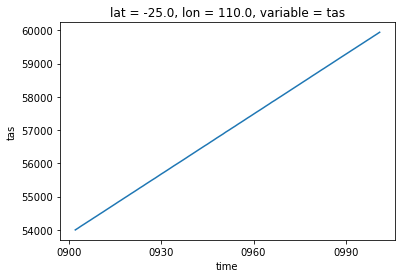

In [317]:
mock_da_2.isel(time=slice(-100, None), lat=0, lon=0).plot()

## Rolling Noise

In [200]:
mock_sn = sn.signal_to_noise(da=mock_da_2, window=window, detrend_kwargs={'method':'polynomial', 'order':1}, 
                            return_all=True)

101, 

In [184]:
mock_sn

<xarray.Dataset>
Dimensions:          (lat: 10, lon: 20, time: 1000, window: 1)
Coordinates:
  * lat              (lat) float64 -25.0 -23.33 -21.67 ... -13.33 -11.67 -10.0
  * lon              (lon) float64 110.0 111.3 112.6 113.9 ... 132.4 133.7 135.0
  * time             (time) object 0001-12-31 00:00:00 ... 1000-12-31 00:00:00
  * window           (window) int64 101
    variable         <U3 'tas'
Data variables:
    signal           (window, lon, lat, time) float64 6.06e+03 6.06e+03 ... nan
    da_for_noise     (lon, lat, time) float64 0.1408 -0.1642 ... -0.8259 -0.6466
    noise            (window, lon, lat, time) float64 0.09739 0.09637 ... nan
    signal_to_noise  (window, lon, lat, time) float64 6.222e+04 ... nan

In [249]:
expcted_signal = window * gradient
expected_noise1 = std1
expected_noise2 = std2
expected_signal_to_noise1 = expcted_signal/expected_noise1
expected_signal_to_noise2 = expcted_signal/expected_noise2

expected_signal_to_noise1

60600.0

In [188]:
expcted_signal

6060

In [192]:
mock_sn.signal.mean().round(0) == expcted_signal

<xarray.DataArray 'signal' ()>
array(True)
Coordinates:
    variable  <U3 'tas'

In [258]:
first_half = slice(0, mid_point-window)
second_half = slice(mid_point+window, -window-10)

In [260]:
percent_diff(mock_sn.isel(time=second_half).noise.mean().values ,expected_noise2) < 5

True

In [261]:
percent_diff(mock_sn.isel(time=first_half).noise.mean().values ,expected_noise1) < 5

True

In [251]:
mock_sn.signal_to_noise.isel(time=0).mean()

<xarray.DataArray 'signal_to_noise' ()>
array(62223.84278532)
Coordinates:
    time      object 0001-12-31 00:00:00
    variable  <U3 'tas'

In [255]:
expected_signal_to_noise1

60600.0

In [264]:
percent_diff(mock_sn.signal_to_noise.isel(time=first_half).mean().values, expected_signal_to_noise1) < 6

True

In [266]:
percent_diff(mock_sn.signal_to_noise.isel(time=second_half).mean().values, expected_signal_to_noise2) < 6

True

In [250]:
mock_sn.signal_to_noise.isel(time=0).mean() - expected_signal_to_noise1

<xarray.DataArray 'signal_to_noise' ()>
array(1623.84278532)
Coordinates:
    time      object 0001-12-31 00:00:00
    variable  <U3 'tas'

In [300]:
len(mock_sn.signal_to_noise.dropna(dim='time').time.values) == (number_points-window+1)
len(mock_sn.signal.dropna(dim='time').time.values) == (number_points-window+1)

True

## Static Noise

In [270]:
# Linear with noise of std 'std' added to the polynomial data. The line should
# be trended with matching order polynomial so noise is just 'std'.
number_points = 1000
gradient = 60
window = 101

std = 0.5
mean = 0

In [271]:
input_mock_values = np.arange(0, number_points, dtype=np.float64) * gradient + np.random.normal(mean, std, number_points)
mock_da = generate_mock_dataset(input_mock_values)

In [272]:
mock_sn = sn.signal_to_noise(da=mock_da, window=window, detrend_kwargs={'method':'polynomial', 'order':1}, 
                             rolling_noise=False, return_all=True)

101, 

In [273]:
mock_sn

<xarray.Dataset>
Dimensions:          (lat: 10, lon: 20, time: 1000, window: 1)
Coordinates:
  * lat              (lat) float64 -25.0 -23.33 -21.67 ... -13.33 -11.67 -10.0
  * lon              (lon) float64 110.0 111.3 112.6 113.9 ... 132.4 133.7 135.0
  * time             (time) object 0001-12-31 00:00:00 ... 1000-12-31 00:00:00
  * window           (window) int64 101
    variable         <U3 'tas'
Data variables:
    signal           (window, lon, lat, time) float64 6.06e+03 6.06e+03 ... nan
    da_for_noise     (lon, lat, time) float64 -0.08982 0.3733 ... -1.082 0.485
    noise            (lon, lat) float64 0.5057 0.5057 0.5057 ... 0.5057 0.5057
    signal_to_noise  (window, lon, lat, time) float64 1.198e+04 ... nan

In [283]:
np.all(mock_sn.noise.round(1).values == std)

True

In [287]:
'time' not in list(mock_sn.noise.coords)

True

In [303]:
expcted_signal = window * gradient
expcted_signal_to_noise = expcted_signal/std

In [290]:
mock_sn.signal.mean().round(0).values == expcted_signal

True

In [296]:
np.nanmax(percent_diff(mock_sn.signal.values,expcted_signal)) < 1

True

In [ ]:
np.nanmax(percent_diff(mock_sn.signal.values,expcted_signal)) < 1

In [308]:
np.nanmax(percent_diff(mock_sn.signal_to_noise.values,expcted_signal_to_noise)) < 3

True

In [301]:
len(mock_sn.signal_to_noise.dropna(dim='time').time.values) == (number_points-window+1)
len(mock_sn.signal.dropna(dim='time').time.values) == (number_points-window+1)

True